Necessary Formulas:

* _for time period, allow filter over 30, 60, 90, 180, 365, custom days_
- todo: put start date and end date for COGS

### Current Monetary Stock Value: 
# $$\Sigma (Quantity of Item_i \times Unit Cost of Item)$$

### Total Items in Stock: 
# $$\Sigma (Quantity of Item_i)$$

### Low Stock Alerts: 
# $$Quantity on Hand ≤ Low Stock Threshold$$

### Out-of-Stock Items
# $$Quantity on Hand ≤ 0 AND restockFlag == 1 $$

### Overstock Items
# $$Quantity on Hand > Low Stock Threshold$$

### Upcoming Deliveries

### Recent Sales/Orders

### Returns/Damaged Goods

### Stock Movement/Velocity
#### Inflow: $$\Sigma (Quantity of Item_i received over time period)$$
#### Outflow: $$\Sigma (Quantity of Item_i sold over time period)$$

### Top Selling Products (by Quantity/Revenue)
#### By Quantity: $$\Sigma (Quantity of Item_i sold for each product over time period)$$
#### By Revenue: $$\Sigma (Quantity of Item_i sold over time period \times retailPrice over time period)$$

### Slow-Moving/Obsolete Stock: A chart or list highlighting items that haven't sold in a long time.

for each item:
# $$Current Date - Last Sale Date > Threshold$$

### Order Fulfillment Rate
# $$\frac{Number of Orders Fulfilled Completely}{Total Number of Orders} \times 100$$

### Inventory Turnover Rate
$$Inventory Turnover Rate = \frac{Cost of Goods Sold}{Average Inventory Value}$$

$$Average Inventory Value = \frac{Beginning Inventory Value + Ending Inventory Value}{2}$$

# $$Inventory Turnover Rate = \frac{Cost of Goods Sold}{\frac{Beginning Inventory Value + Ending Inventory Value}{2}}$$

### Days Sales of Inventory (DSI) / Days on Hand
# $$DSI = \frac{Ave Inventory Value}{Cost of Goods Sold} \times timePeriod$$

### Reorder Point Analysis
# $$(Ave Num Units Sold per Day \times Lead Time in Days)+Safety Stock$$
- Lead Time: Time (in days) between placing an order and receiving it.

### Safety Stock Calculation (per Product) **Might Remove**
# $$(Max Daily Sales - Average Daily Sales) \times Lead Time to buy more Products$$

### ABC Analysis

- A-Items: High-value products that account for a large percentage of total inventory value (e.g., top 10-20% of items contributing to 70-80% of value). These require close monitoring.
- B-Items: Medium-value products.
- C-Items: Low-value products that make up a large percentage of total inventory items but a small percentage of total value.

1. Calculate annual usage value for each item
# $$Annual Demand \times Unit Cost$$
2. Rank items by usage value in descending order
3. Calculate cumulative percentage of total usage value and cumulative percentage of total items
4. Define your A, B, and C cut-off points based on these cumulative percentages
- Helps prioritize inventory management efforts

### Demand Forecasting

#### Simple Moving Average: Average of sales over the last ’n’ periods
#### Regression Analysis (?????)

### Stockout Rate
# $$(Number of Stockouts \div Total Number of Order Lines) \times 100$$

### Fill Rate
# $$(Number of Orders Fulfilled on First Attempt \div Total Number of Orders) \times 100$$
- Can also be by line item or quantity
- Measures the percentage of demand that could not be met immediately from existing inventory (stockout rate) or the percentage of demand that was met successfully (fill rate).

### Return on Investment (ROI) of Inventory
# Return of Investment: $$ROI = \frac{Retail Price - Supplier Buying Price}{Supplier Buying Price}\times100%$$
# $$\frac{(Gross Profit from Sales − Cost of Holding Inventory)}{Cost of Holding Inventory}$$

### Obsolete Inventory
# $$Obsolete Inventory Value = \Sigma (Quantity of Obsolete Item_i \times Unit Cost of Item_i)$$
- The value of stock that is no longer sellable or useful

### Shrinkage Analysis
# $$Shrinkage Rate = \frac{Book Inventory Value - Physical Inventory Value}{Book Inventory Value} \times 100$$
- The loss of inventory due to factors like theft, damage, errors, or spoilage. It compares what your records say you have versus what you actually have.

# Cost of Goods Sold: $$COGS = \frac{-b \pm \sqrt{Beginning Inventory Value - 4ac}}{2a}$$

# Gross Profit: $$Revenue - COGS$$

# Set up the Python environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import os
from dotenv import load_dotenv

current_dir = os.getcwd()
dotenv_path = os.path.join(current_dir, '..', 'backend', '.env')

load_dotenv(dotenv_path=dotenv_path)

my_variable = os.getenv('MY_VARIABLE')
database_url = os.getenv('DATABASE_URL')

user = os.getenv('DB_USER')
pw   = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
db   = os.getenv('DB_NAME')

engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}/{db}")

### Define the time period of the data

In [2]:
start_date = pd.to_datetime('2024-01-01')
end_date   = pd.to_datetime('2025-12-31')

# Load tables into DataFrames

In [3]:
    df_products      = pd.read_sql_table("Product",      con=engine)
    df_users         = pd.read_sql_table("Users",        con=engine)
    df_stock_entry   = pd.read_sql_table("StockEntry",   con=engine)
    df_stock_withd   = pd.read_sql_table("StockWithdrawal", con=engine)
    df_orders        = pd.read_sql_table("Orders",       con=engine)
    df_order_info    = pd.read_sql_table("OrderInfo",    con=engine)
    df_returns       = pd.read_sql_table("ReturnExchange",     con=engine)
    df_return_info   = pd.read_sql_table("ReturnExchangeInfo", con=engine)
    df_audit         = pd.read_sql_table("AuditLog",     con=engine)

# Compute Cost of Goods Sold (COGS) per product

In [4]:
# 2a. Only “paid” orders
paid_orders = df_orders[df_orders['paymentStatus']=='paid']

# 2b. Join orders → order lines → product costs
sales = (
    paid_orders[['orderId', 'dateOrdered']]
    .merge(df_order_info, on='orderId')
    .merge(df_products[['productId', 'cost', 'productName']], on='productId')
)

# 2c. Filter to period and compute COGS
sales['dateOrdered'] = pd.to_datetime(sales['dateOrdered'])
sales_period = sales[(sales['dateOrdered'] >= start_date) & (sales['dateOrdered'] <= end_date)]
sales_period['cogs'] = sales_period['quantity'] * sales_period['cost']

# 2d. Total COGS per product
cogs_per_prod = (sales_period
    .groupby(['productId','productName'])['cogs']
    .sum()
    .rename('total_cogs')
    .reset_index()
)

print("Total COGS per product:")
print(cogs_per_prod)

Total COGS per product:
    productId                     productName  total_cogs
0           3                      FZD CNF FL   1416000.0
1           6                     FREITAS ALC    780000.0
2           9          LIN GAO YUAN ALC FL ST    715000.0
3          11                        REVOLDIA   1012000.0
4          14              FZD ALC FL, ST, CS    624000.0
5          17       MIZUTANI JUN SUPER ZLC FL   1012000.0
6          20  OVTCHAROV INNERFORCE ALC ST FL    845000.0
7          23           HARIMOTO SUPER ALC FL    722000.0
8          26                       KENTA ALC    520000.0
9          29           SUPREME SPEED PEN, FL    304000.0
10         32                      DIGNICS090    289100.0
11         35                  SK-7 KORBEL FL    312000.0
12         38                 GARAYDIA ALC FL    737500.0
13         41                      FALCIMA FL    324500.0
14         44                    TIMOBOLL CAF    222000.0
15         47                  PETR KORBEL FL   

## Compute beginning & ending inventory levels

In [5]:
# 3a. Beginning on-hand = total received – total withdrawn **before** start_date
# Map withdrawals → productId
withdrawals = (
    df_stock_withd[['entryId','quantityWithdrawn','dateWithdrawn']]
    .merge(df_stock_entry[['entryId','productId']], on='entryId')
)
# Sum
received_before = (df_stock_entry[df_stock_entry['dateReceived'] < start_date]
    .groupby('productId')['quantityReceived']
    .sum()
    .rename('total_received_before')
)
withdrawn_before = (withdrawals[pd.to_datetime(withdrawals['dateWithdrawn']) < start_date]
    .groupby('productId')['quantityWithdrawn']
    .sum()
    .rename('total_withdrawn_before')
)
beg_inv = (received_before.subtract(withdrawn_before, fill_value=0)
           .reset_index().rename(columns={0:'beg_units', 'total_received_before':'beg_units'}))

# 3b. Ending on-hand from current snapshot
end_inv = df_products[['productId','productName','stockOnHand','cost']]


## Build the turnover table

In [6]:
# Merge beginning, ending, and COGS
turnover = (
    cogs_per_prod
    .merge(beg_inv,  on=['productId'], how='left')
    .merge(end_inv,  on=['productId','productName'], how='left')
    .fillna(0)
)

# Average units and average inventory **value**
turnover['avg_units'] = (turnover['beg_units'] + turnover['stockOnHand']) / 2
turnover['avg_inventory_value'] = turnover['avg_units'] * turnover['cost']

# Turnover rate per product
turnover['turnover_rate'] = turnover['total_cogs'] / turnover['avg_inventory_value']

print("Turnover rate per product:")
print(turnover[['productId', 'productName', 'turnover_rate']])


Turnover rate per product:
    productId                     productName  turnover_rate
0           3                      FZD CNF FL           11.8
1           6                     FREITAS ALC           12.0
2           9          LIN GAO YUAN ALC FL ST           11.0
3          11                        REVOLDIA            8.8
4          14              FZD ALC FL, ST, CS            9.6
5          17       MIZUTANI JUN SUPER ZLC FL            8.8
6          20  OVTCHAROV INNERFORCE ALC ST FL           13.0
7          23           HARIMOTO SUPER ALC FL            7.6
8          26                       KENTA ALC            8.0
9          29           SUPREME SPEED PEN, FL            7.6
10         32                      DIGNICS090            9.8
11         35                  SK-7 KORBEL FL           10.4
12         38                 GARAYDIA ALC FL           11.8
13         41                      FALCIMA FL           11.8
14         44                    TIMOBOLL CAF            7

/var/folders/hv/jnmd_b7123gfd5f464464gh80000gn/T/ipykernel_62001/2361431120.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


## Visualize: Top 10 Products by Turnover Rate

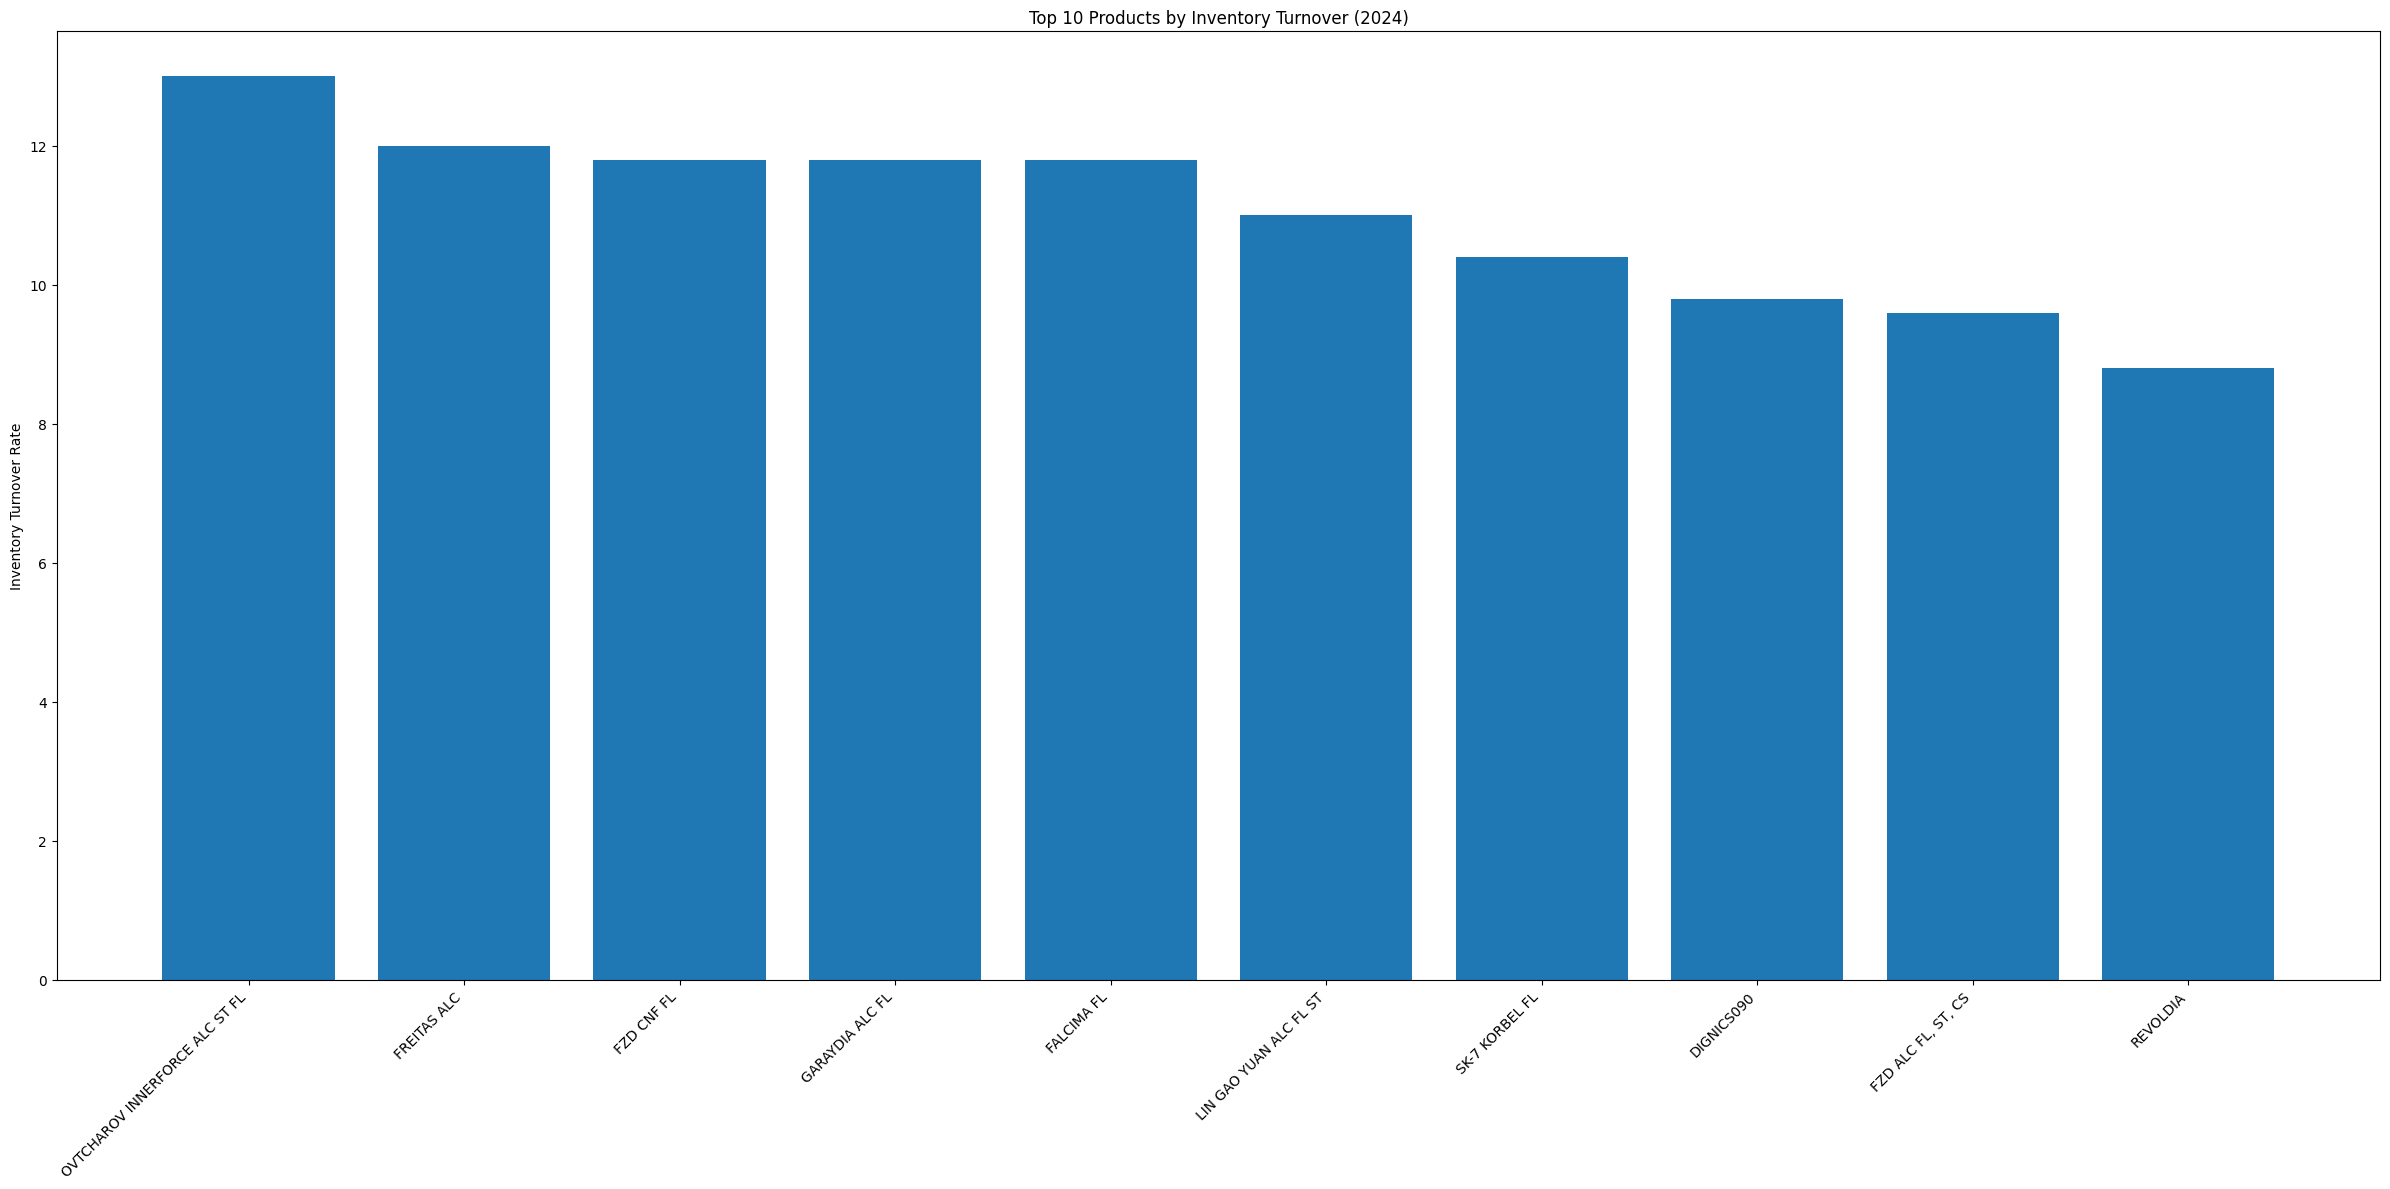

In [7]:
top10 = turnover.sort_values('turnover_rate', ascending=False).head(10)

plt.figure(figsize=(24,12))
plt.bar(top10['productName'], top10['turnover_rate'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Inventory Turnover Rate')
plt.title('Top 10 Products by Inventory Turnover (2024)')
plt.tight_layout()
plt.show()


# Stock-level snapshots

## Current Monetary Stock Value

In [8]:
# add a column for the value on hand per product
df_products['monetaryValue'] = df_products['stockOnHand'] * df_products['cost']

# overall monetary value
current_monetary_value = df_products['monetaryValue'].sum()
print(f"Current monetary stock value: ₱{current_monetary_value:,.2f}")


Current monetary stock value: ₱14,403,328.82


## Total Items in Stock

In [9]:
total_items = df_products['stockOnHand'].sum()
print(f"Total units in stock: {total_items:,}")

Total units in stock: 27,893


## Total Items per Product

In [10]:
total_items_per_product = df_products[['productId', 'productName', 'stockOnHand']].copy()
total_items_per_product.rename(columns={'stockOnHand': 'total_items'}, inplace=True)
print("Total Items per Product:")
print(total_items_per_product)

Total Items per Product:
     productId               productName  total_items
0            1   LIN YUN JU SUPER ZLC FL           10
1            2  FZD SUPER ALC FL, ST, CS           10
2            3                FZD CNF FL           10
3            4     SUPER ALC VISCARIA FL           10
4            5              TIMOBOLL ZLC           10
..         ...                       ...          ...
876        877               Product 496           90
877        878               Product 497           16
878        879               Product 498            8
879        880               Product 499           17
880        881               Product 500           82

[881 rows x 3 columns]


## Low-Stock Alerts

     productId               productName  stockOnHand
0            1   LIN YUN JU SUPER ZLC FL           10
1            2  FZD SUPER ALC FL, ST, CS           10
2            3                FZD CNF FL           10
3            4     SUPER ALC VISCARIA FL           10
4            5              TIMOBOLL ZLC           10
..         ...                       ...          ...
871        872               Product 491           62
872        873               Product 492           43
873        874               Product 493            6
879        880               Product 499           17
880        881               Product 500           82

[642 rows x 3 columns]


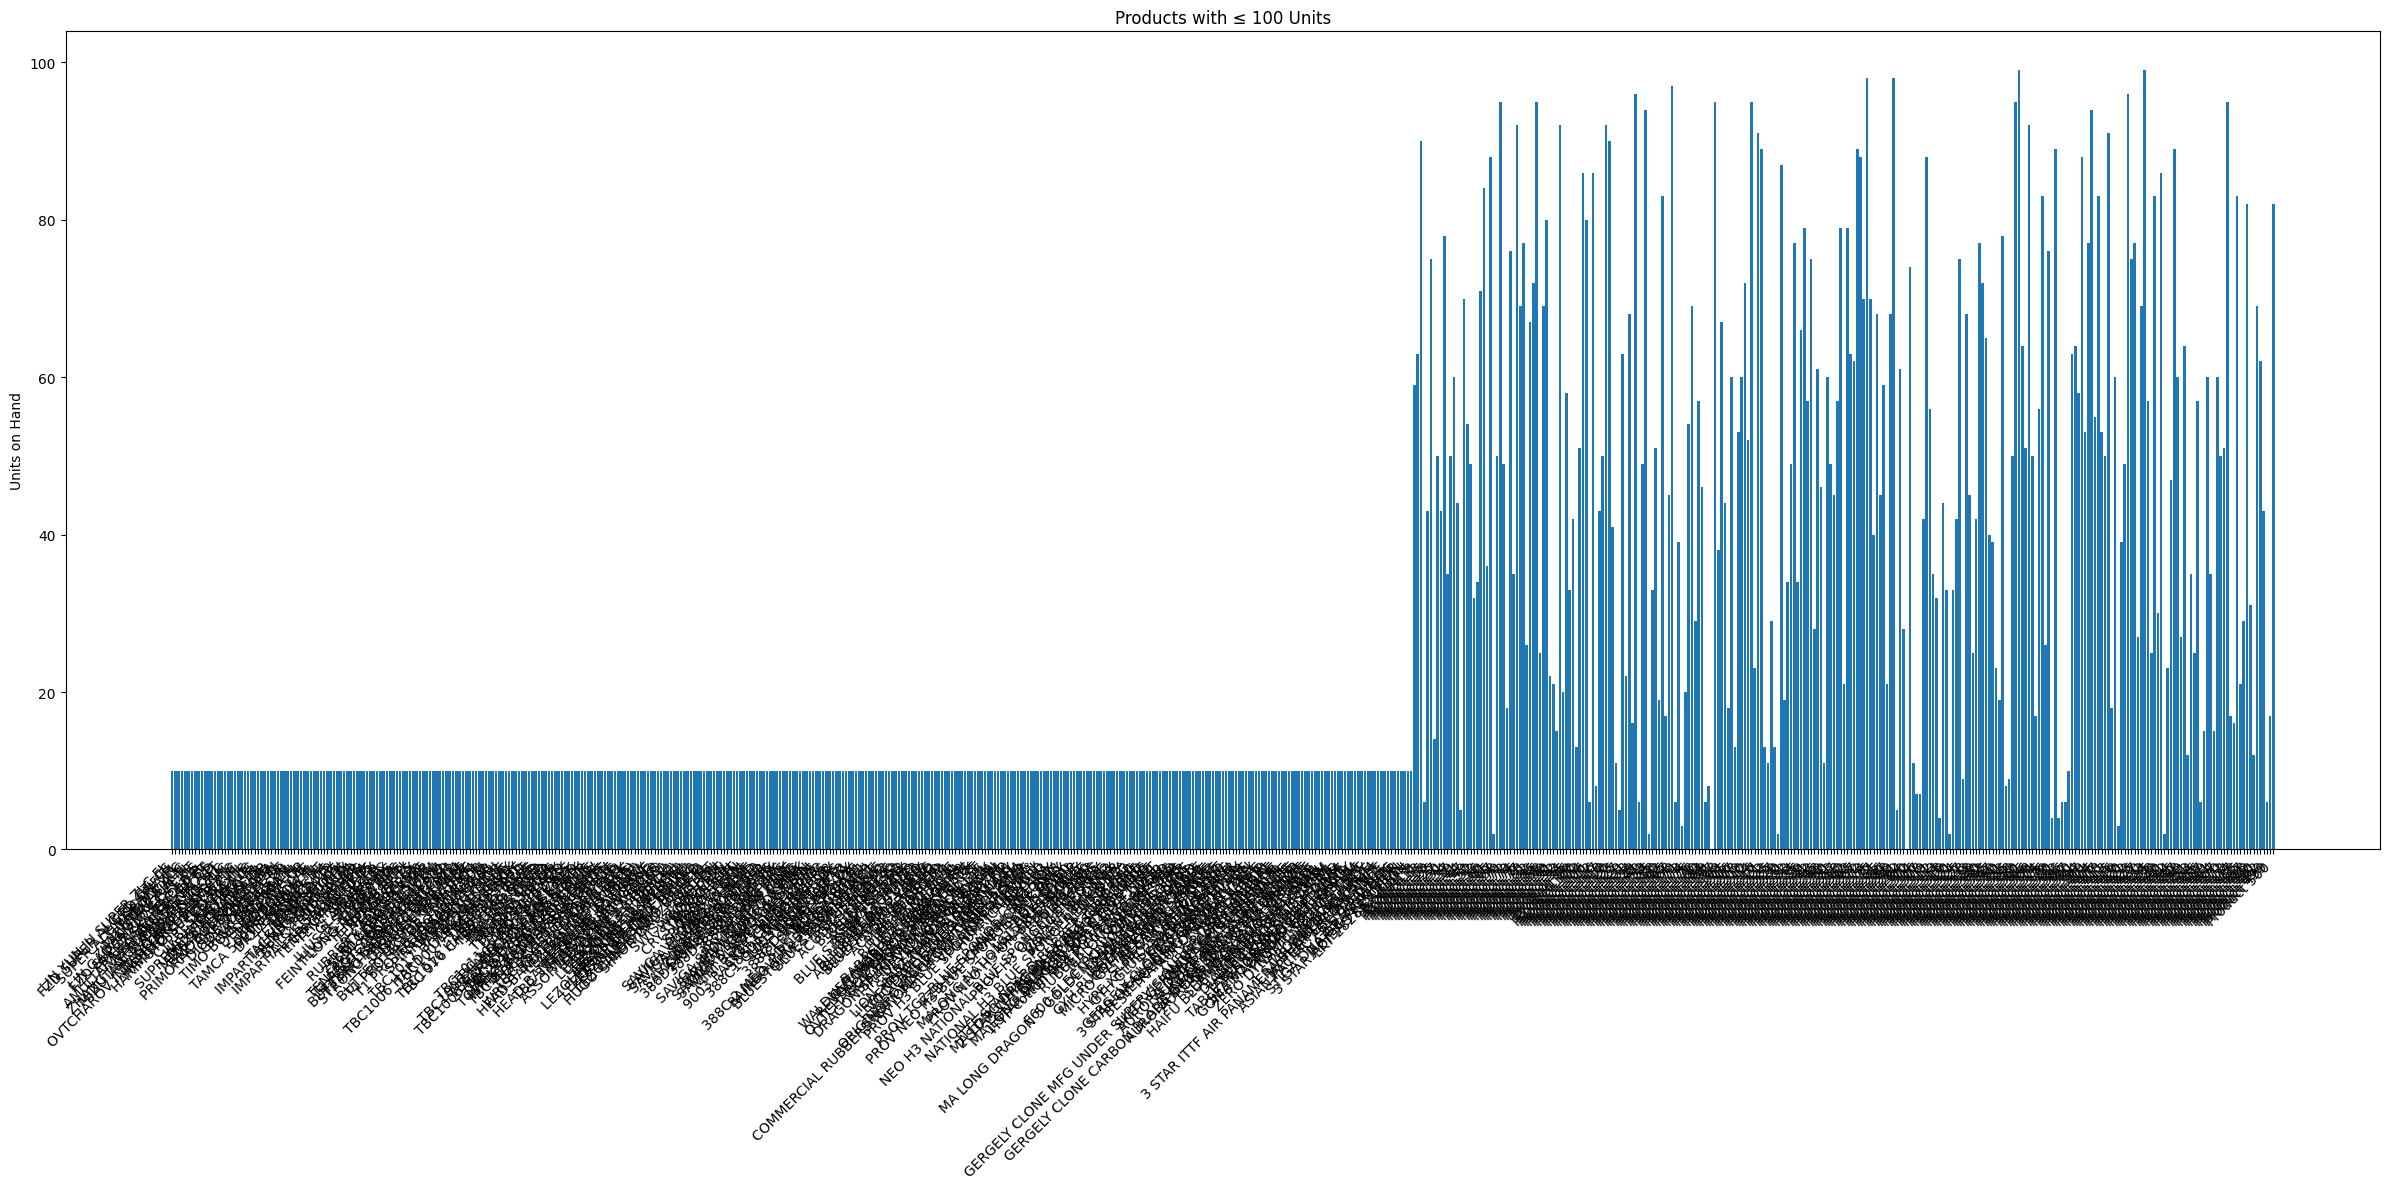

In [40]:
low_stock_threshold = 100
low_stock = df_products[(df_products['stockOnHand'] <= low_stock_threshold) &
                        (df_products['restockFlag'] != 1)
                        ]

# list
print(low_stock[['productId','productName','stockOnHand']])

# bar chart
plt.figure(figsize=(24,12))
plt.bar(low_stock['productName'], low_stock['stockOnHand'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Units on Hand')
plt.title(f'Products with ≤ {low_stock_threshold} Units')
plt.tight_layout()
plt.show()

## Out‐of‐Stock Items

In [43]:
out_of_stock = df_products[(df_products['stockOnHand'] == 0) & (df_products['restockFlag'] != 1)]

print(out_of_stock[['productId','productName']])


     productId  productName
569        570  Product 189
674        675  Product 294


## Overstock Items

In [46]:
overstock_threshold = 50
overstock = df_products[df_products['stockOnHand'] >= overstock_threshold]
print(overstock[['productId','productName','stockOnHand']])


     productId  productName  stockOnHand
381        382    Product 1           62
384        385    Product 4           74
385        386    Product 5           59
386        387    Product 6           84
388        389    Product 8           63
..         ...          ...          ...
871        872  Product 491           62
874        875  Product 494           50
875        876  Product 495           81
876        877  Product 496           90
880        881  Product 500           82

[246 rows x 3 columns]


# Deliveries, Sales & Returns

## Upcoming Deliveries

In [14]:
now = pd.Timestamp.now().normalize()
upcoming = df_stock_entry[pd.to_datetime(df_stock_entry['dateReceived']) >= now]
print(upcoming.sort_values('dateReceived')[['productId','branchName','dateReceived','quantityReceived']])


     productId branchName dateReceived  quantityReceived
29          31       Main   2025-07-21                61
59          11       Main   2025-07-21                29
89          41       Main   2025-07-21                48
119         21       Main   2025-07-21                93
149          1       Main   2025-07-21                80
179         31       Main   2025-07-21                24
209         11       Main   2025-07-21                 6
239         41       Main   2025-07-21                 3
269         21       Main   2025-07-21                46
299          1       Main   2025-07-21                40
329         31       Main   2025-07-21                97
359         11       Main   2025-07-21                24
389         41       Main   2025-07-21                44
419         21       Main   2025-07-21                71
449          1       Main   2025-07-21                52
479         31       Main   2025-07-21                 5


## Recent Sales / Orders

In [15]:
cutoff = now - pd.Timedelta(days=30)
recent = sales[(sales['dateOrdered'] >= cutoff)]

# # orders
print(f"Paid orders in last 30d: {recent['orderId'].nunique()}")

# total revenue
recent = recent.assign(revenue = recent['quantity'] * recent['unitPriceAtPurchase'])
print(f"Sales revenue last 30d: ₱{recent['revenue'].sum():,.2f}")


Paid orders in last 30d: 17
Sales revenue last 30d: ₱44,788.98


## Returns / Damaged Goods

In [16]:
# join return header + details
returns = (
    df_returns[['transactionId','dateTransaction','transactionStatus']]
    .merge(df_return_info, on='transactionId')
    .merge(df_products[['productId','productName']], left_on='returnedProductId', right_on='productId')
)
print(returns[['transactionId','dateTransaction','productName','returnedQuantity','transactionStatus']])


     transactionId dateTransaction               productName  \
0                1      2025-07-20           MIZUTANI JUN FL   
1                2      2025-07-19         ZHANG JIKE ALC FL   
2                3      2025-07-18    LIN GAO YUAN ALC FL ST   
3                4      2025-07-17   FZD SUPER ZLC FL ST. CS   
4                5      2025-07-16                  REVOLDIA   
..             ...             ...                       ...   
495            496      2025-07-05  FZD SUPER ALC FL, ST, CS   
496            497      2025-07-04                FZD CNF FL   
497            498      2025-07-03     SUPER ALC VISCARIA FL   
498            499      2025-07-02              TIMOBOLL ZLC   
499            500      2025-07-01               FREITAS ALC   

     returnedQuantity transactionStatus  
0                   3          replaced  
1                   3            denied  
2                   5          refunded  
3                   3          replaced  
4                   5

# Movement / Velocity & Top/Slow Movers

## Stock Movement / Velocity

Daily in vs. out over the period:

Stock In vs. Stock Out (Time-series)

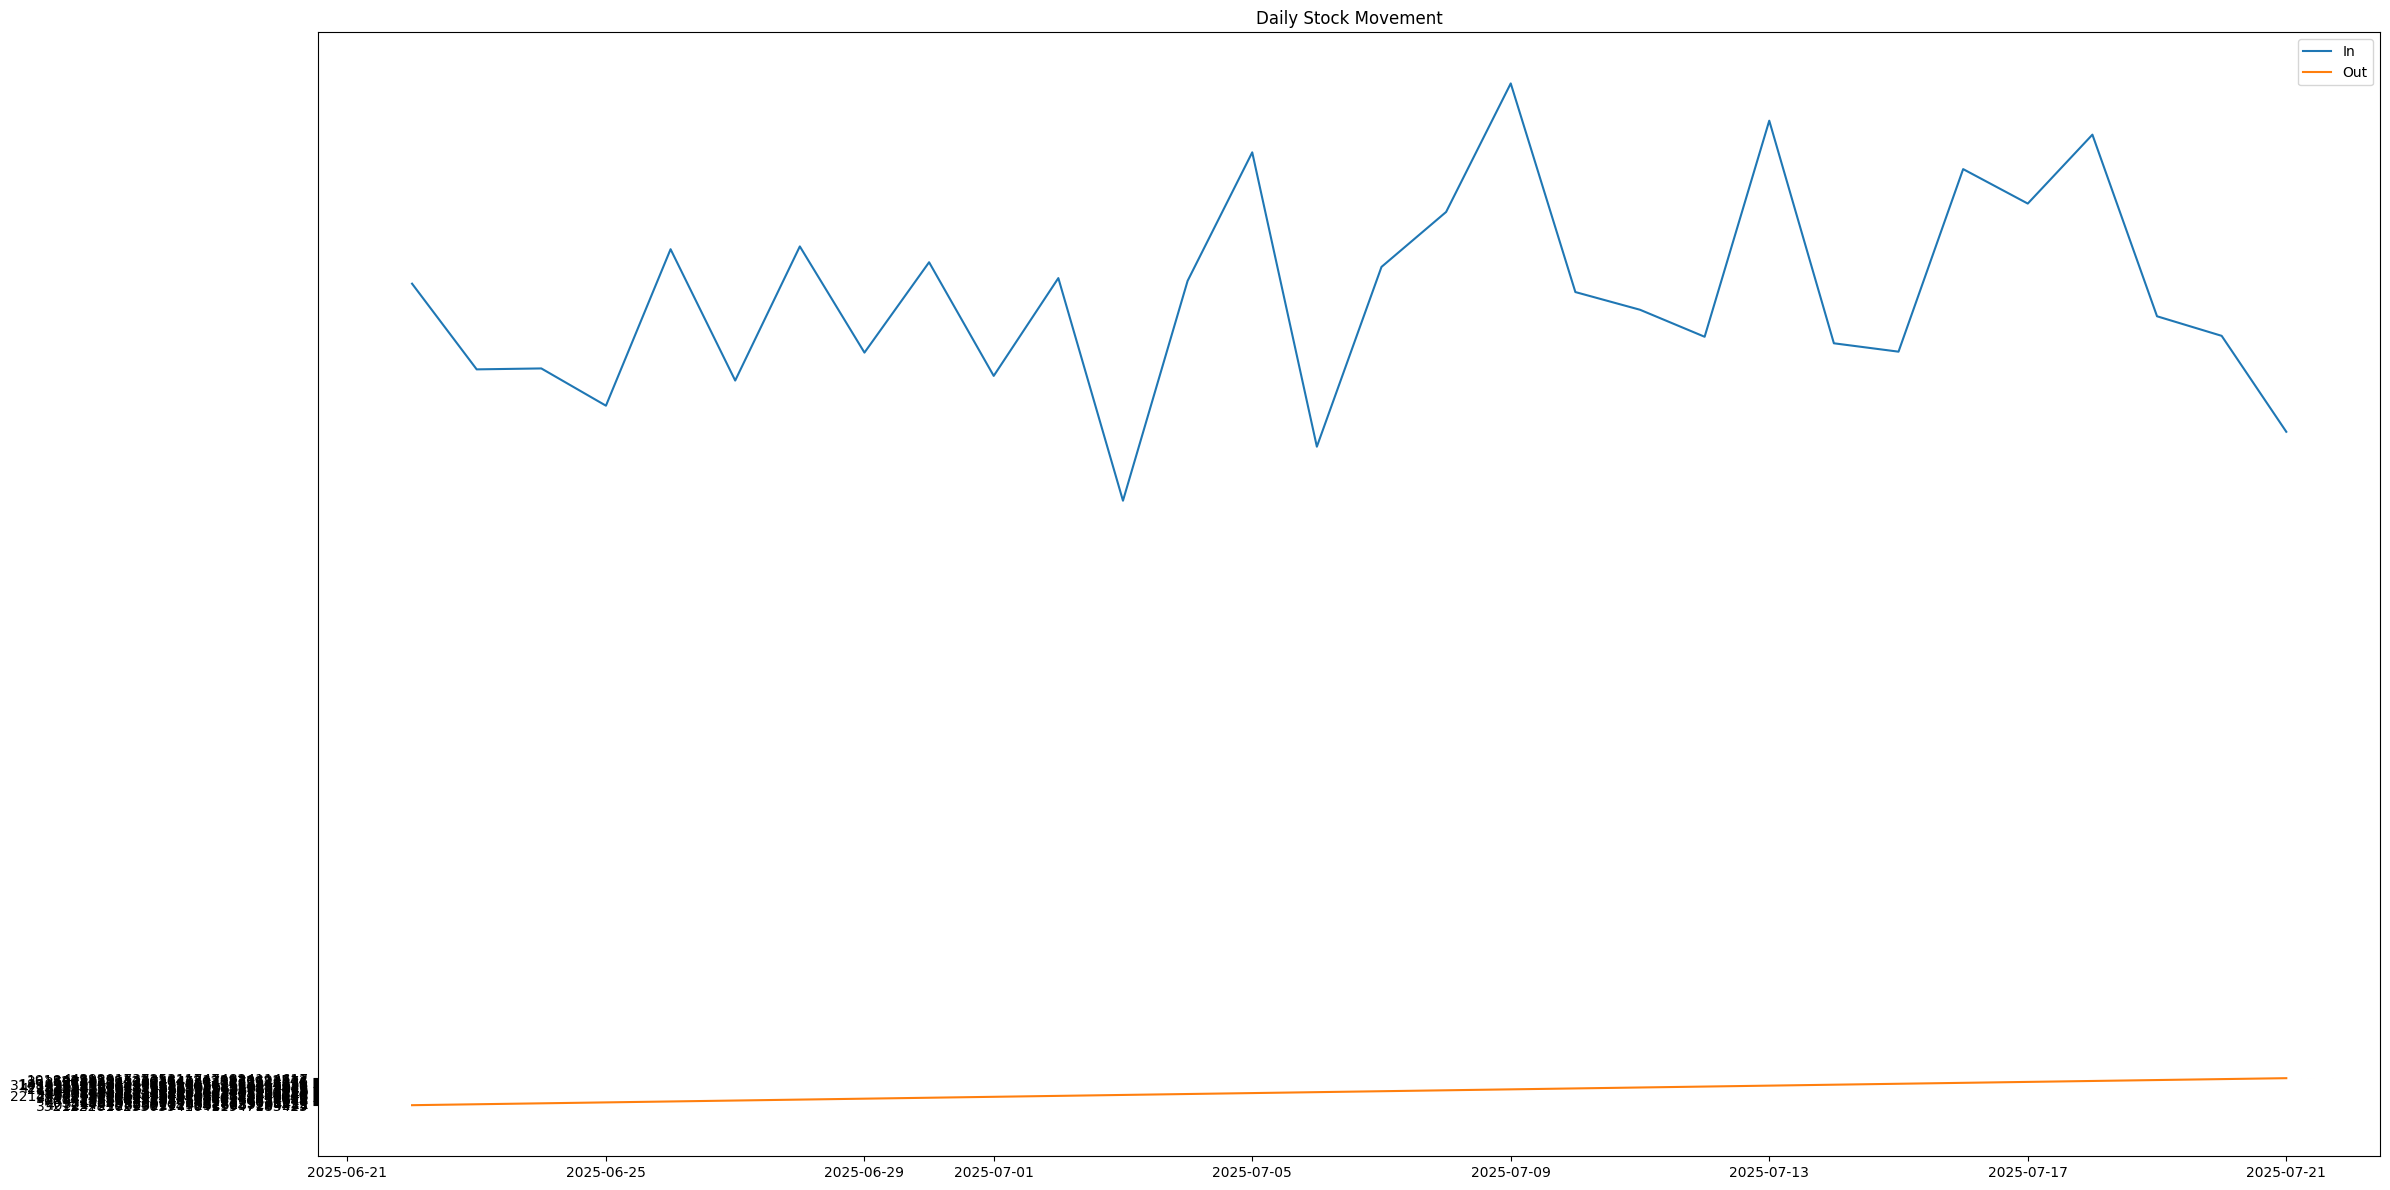

In [17]:
# prepare
in_ = df_stock_entry.assign(date=pd.to_datetime(df_stock_entry['dateReceived']))
out = (
    df_stock_withd.rename(columns={'dateWithdrawn':'date','quantityWithdrawn':'qty'})
    .merge(df_stock_entry[['entryId','productId']], on='entryId')
    .assign(date=lambda d: pd.to_datetime(d['date']))
)

# aggregate & resample
daily_in  = in_.set_index('date')['quantityReceived'].resample('D').sum().fillna(0)
daily_out = out.set_index('date')['qty'].resample('D').sum().fillna(0)

# plot
plt.figure(figsize=(24,12))
plt.plot(daily_in.index, daily_in, label='In')
plt.plot(daily_out.index, daily_out, label='Out')
plt.legend(); plt.title('Daily Stock Movement'); plt.tight_layout()
plt.show()


## Top-Selling Products


by quantity

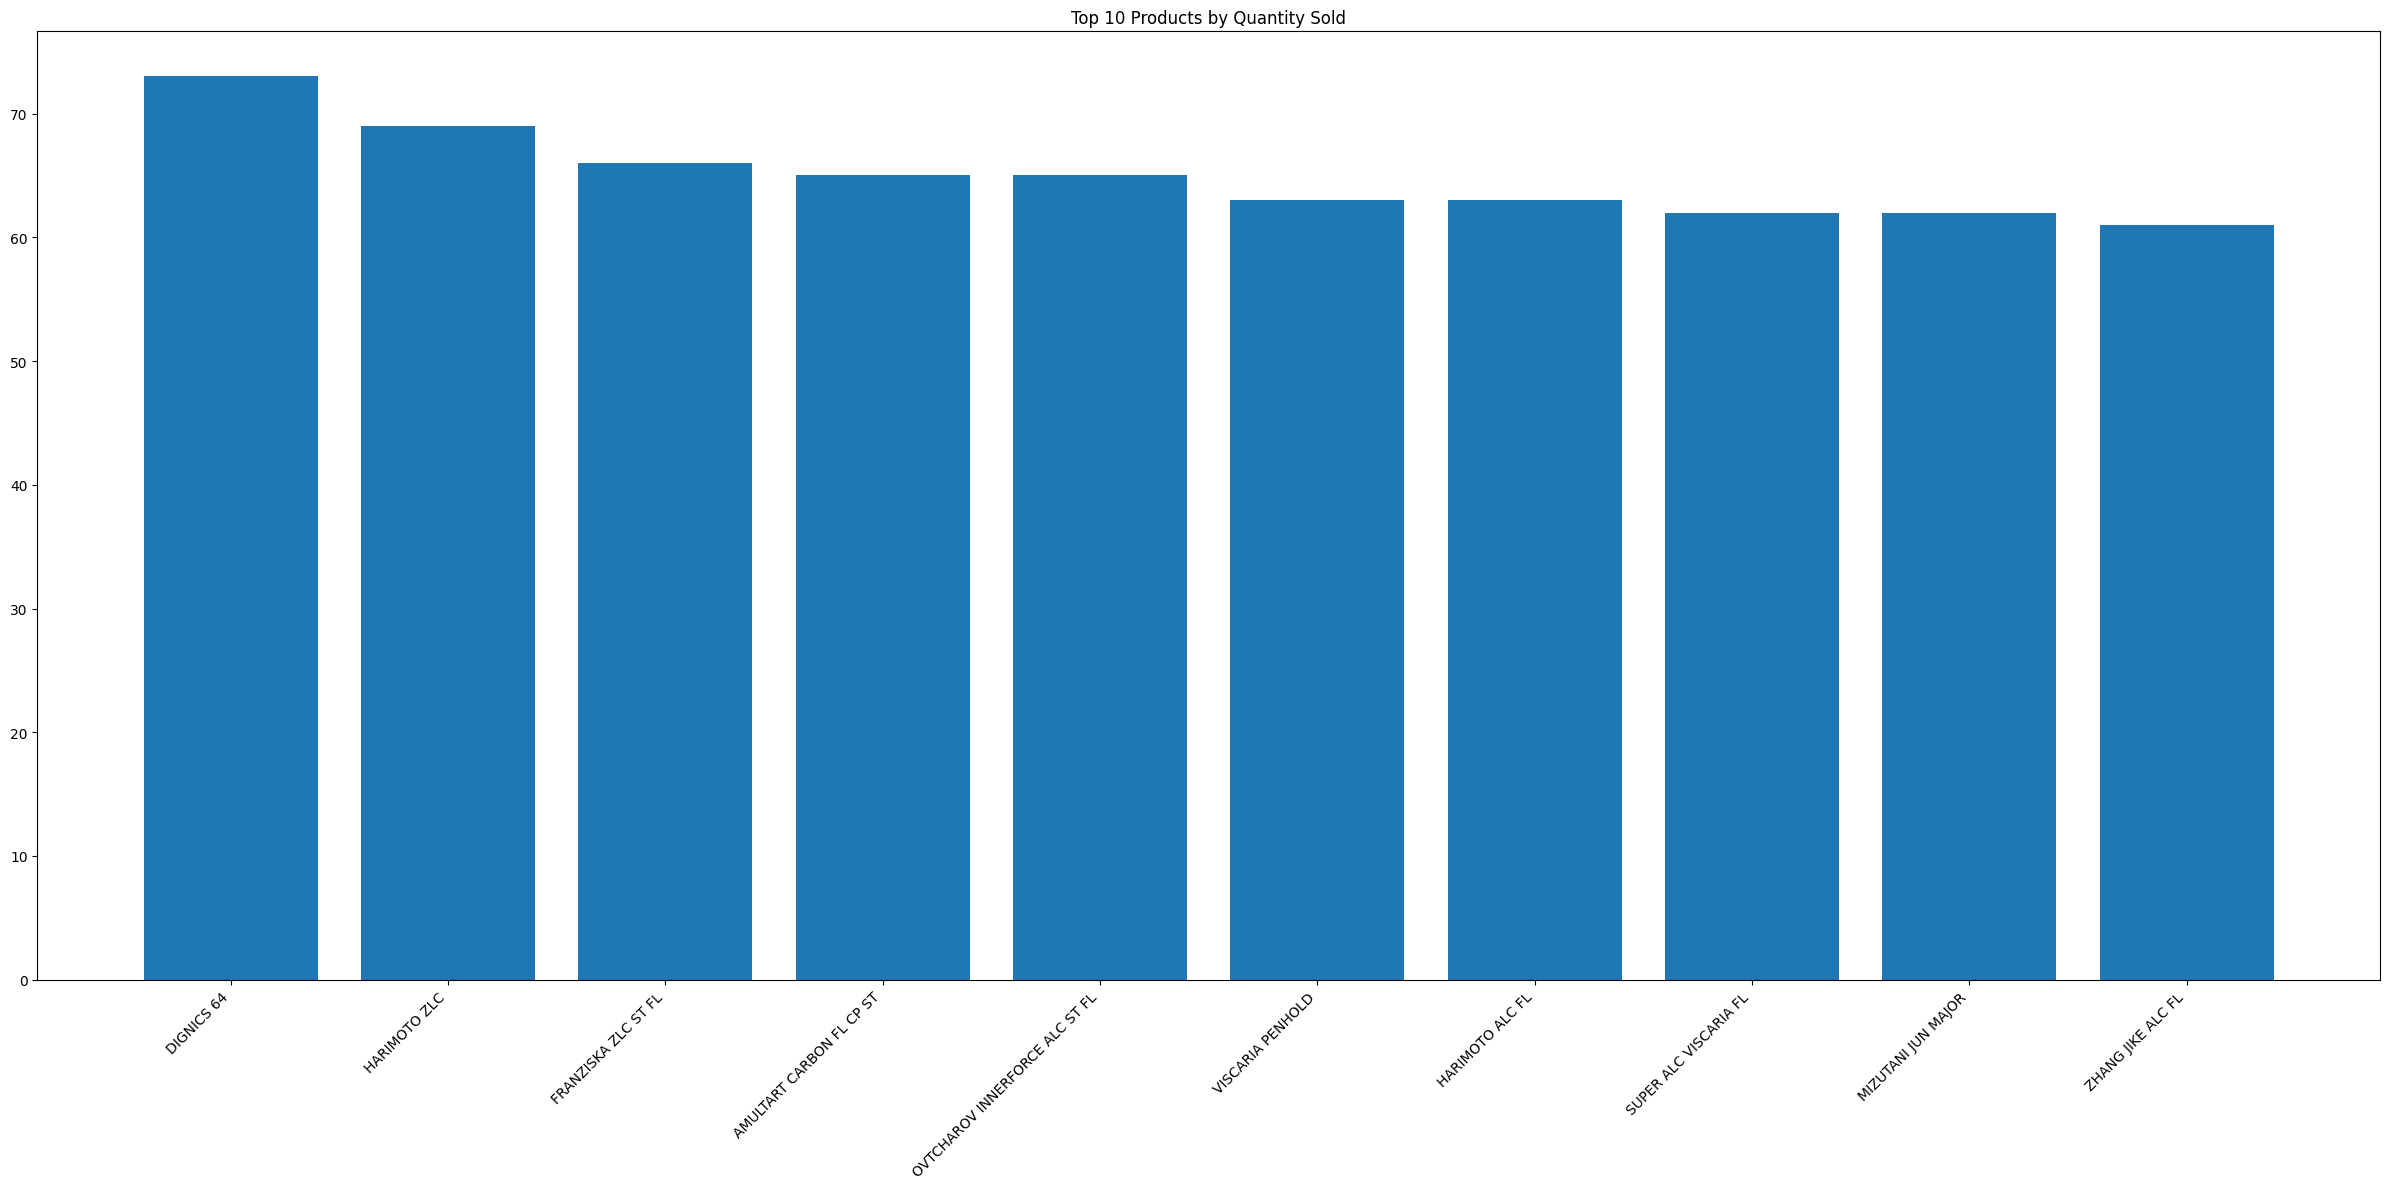

In [18]:
top_qty = (
    df_order_info
    .groupby('productId')['quantity']
    .sum()
    .nlargest(10)
    .reset_index()
    .merge(df_products[['productId','productName']], on='productId')
)
plt.figure(figsize=(24,12))
plt.bar(top_qty['productName'], top_qty['quantity'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Quantity Sold')
plt.tight_layout()
plt.show()


by revenue

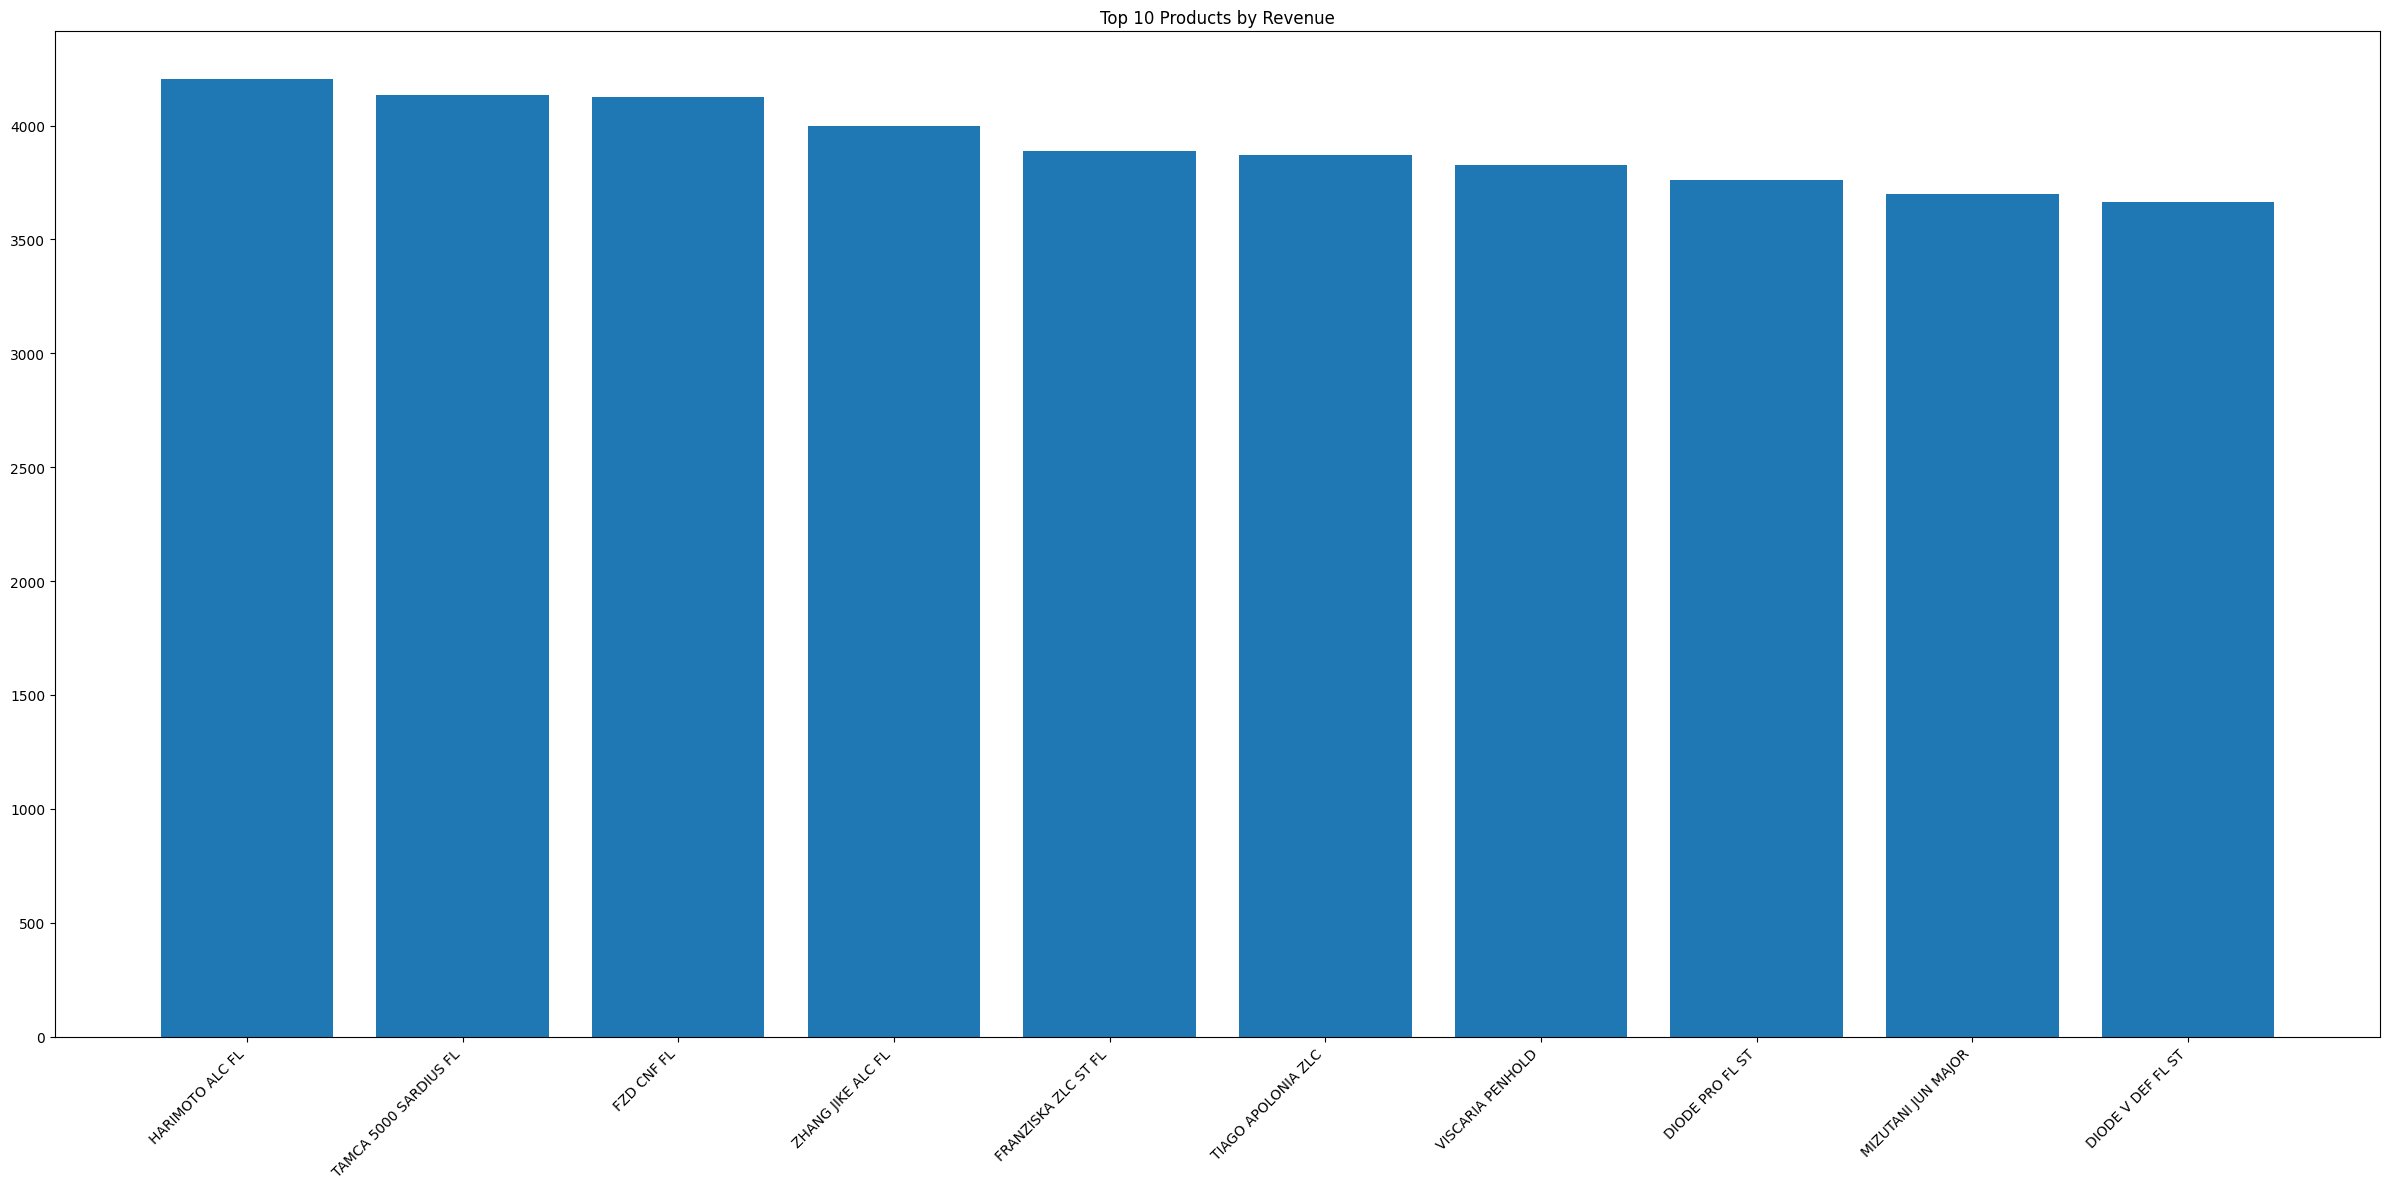

In [19]:
rev = df_order_info.assign(revenue=df_order_info['quantity']*df_order_info['unitPriceAtPurchase'])
top_rev = (
    rev.groupby('productId')['revenue']
    .sum()
    .nlargest(10)
    .reset_index()
    .merge(df_products[['productId','productName']], on='productId')
)
plt.figure(figsize=(24,12))
plt.bar(top_rev['productName'], top_rev['revenue'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()


## Slow-Moving / Obsolete Stock

no sales in last 90 days

In [20]:
# make sure 'now' is defined
now = pd.Timestamp.now().normalize()

# 1) get last sale date per product
last_sale = (
    sales
      .groupby('productId')['dateOrdered']
      .max()
      .reset_index()
)

# 2) ensure it's datetime (often already is)
last_sale['dateOrdered'] = pd.to_datetime(last_sale['dateOrdered'])

# 3) compute days since last sale
last_sale['days_since'] = (now - last_sale['dateOrdered']).dt.days

# 4) filter and merge
slow = (
    last_sale[last_sale['days_since'] > 90]
      .merge(df_products[['productId','productName','stockOnHand']],
             on='productId')
)

print(slow[['productName','stockOnHand','days_since']])


Empty DataFrame
Columns: [productName, stockOnHand, days_since]
Index: []


In [21]:
now = pd.Timestamp.now().normalize()

last_sale = (
    sales
      .groupby('productId')['dateOrdered']
      .max()
      .reset_index()
      .assign(
        # convert the new column to datetime
        dateOrdered=lambda df: pd.to_datetime(df['dateOrdered']),
        # then compute days_since from that
        days_since = lambda df: (now - df['dateOrdered']).dt.days
      )
)

slow = last_sale[last_sale['days_since'] > 90] \
         .merge(df_products[['productId','productName','stockOnHand']],
                on='productId')

print(slow[['productName','stockOnHand','days_since']])


Empty DataFrame
Columns: [productName, stockOnHand, days_since]
Index: []


# Fulfillment & Inventory Ratios

## Order Fulfillment Rate

If “paid” = fulfilled IDK AAAAAAAA

In [22]:
total_orders = df_orders.shape[0]
fulfilled    = paid_orders.shape[0]
rate = fulfilled / total_orders * 100
print(f"Fulfillment Rate: {rate:.1f}%")


Fulfillment Rate: 33.4%


## Inventory Turnover Rate

In [23]:
overall_turnover = sales_period['cogs'].sum() / turnover['avg_inventory_value'].sum()
print(f"Overall Inv. Turnover Rate: {overall_turnover:.2f}")


Overall Inv. Turnover Rate: 9.87


## Days Sales of Inventory (DSI) / Days on Hand

In [24]:
period_days = (end_date - start_date).days
total_cogs = sales_period['cogs'].sum()
avg_inv_val = turnover['avg_inventory_value'].sum()
DSI = avg_inv_val / (total_cogs / period_days)
print(f"Days Sales of Inventory: {DSI:.1f} days")


Days Sales of Inventory: 74.0 days


## Reorder Point & Safety Stock

In [25]:
# avg daily usage per product
daily_usage = sales_period.groupby('productId')['quantity'].sum() / period_days

lead_time_days = 7  # example
# assume safety_stock pre‐computed or constant:
safety_stock = 20

reorder_point = (daily_usage * lead_time_days + safety_stock).rename('reorderPoint').reset_index()
print(reorder_point.merge(df_products[['productId','productName']], on='productId'))


    productId  reorderPoint                     productName
0           3     20.565753                      FZD CNF FL
1           6     20.575342                     FREITAS ALC
2           9     20.527397          LIN GAO YUAN ALC FL ST
3          11     20.421918                        REVOLDIA
4          14     20.460274              FZD ALC FL, ST, CS
5          17     20.421918       MIZUTANI JUN SUPER ZLC FL
6          20     20.623288  OVTCHAROV INNERFORCE ALC ST FL
7          23     20.364384           HARIMOTO SUPER ALC FL
8          26     20.383562                       KENTA ALC
9          29     20.364384           SUPREME SPEED PEN, FL
10         32     20.469863                      DIGNICS090
11         35     20.498630                  SK-7 KORBEL FL
12         38     20.565753                 GARAYDIA ALC FL
13         41     20.565753                      FALCIMA FL
14         44     20.354795                    TIMOBOLL CAF
15         47     20.421918             

## Safety Stock Calculation

Using service‐level z and usage variability

In [ ]:
# daily usage series
du = sales.set_index('dateOrdered').groupby('productId')['quantity'].resample('D').sum().fillna(0)
std_usage = du.groupby('productId').std()

z = 1.65  # ~95% service level
ss = (z * std_usage * np.sqrt(lead_time_days)).rename('safetyStock').reset_index()
print(ss.head())


   productId  safetyStock
0          3          NaN
1          6          NaN
2          9          NaN
3         11          NaN
4         14          NaN


## ABC Analysis

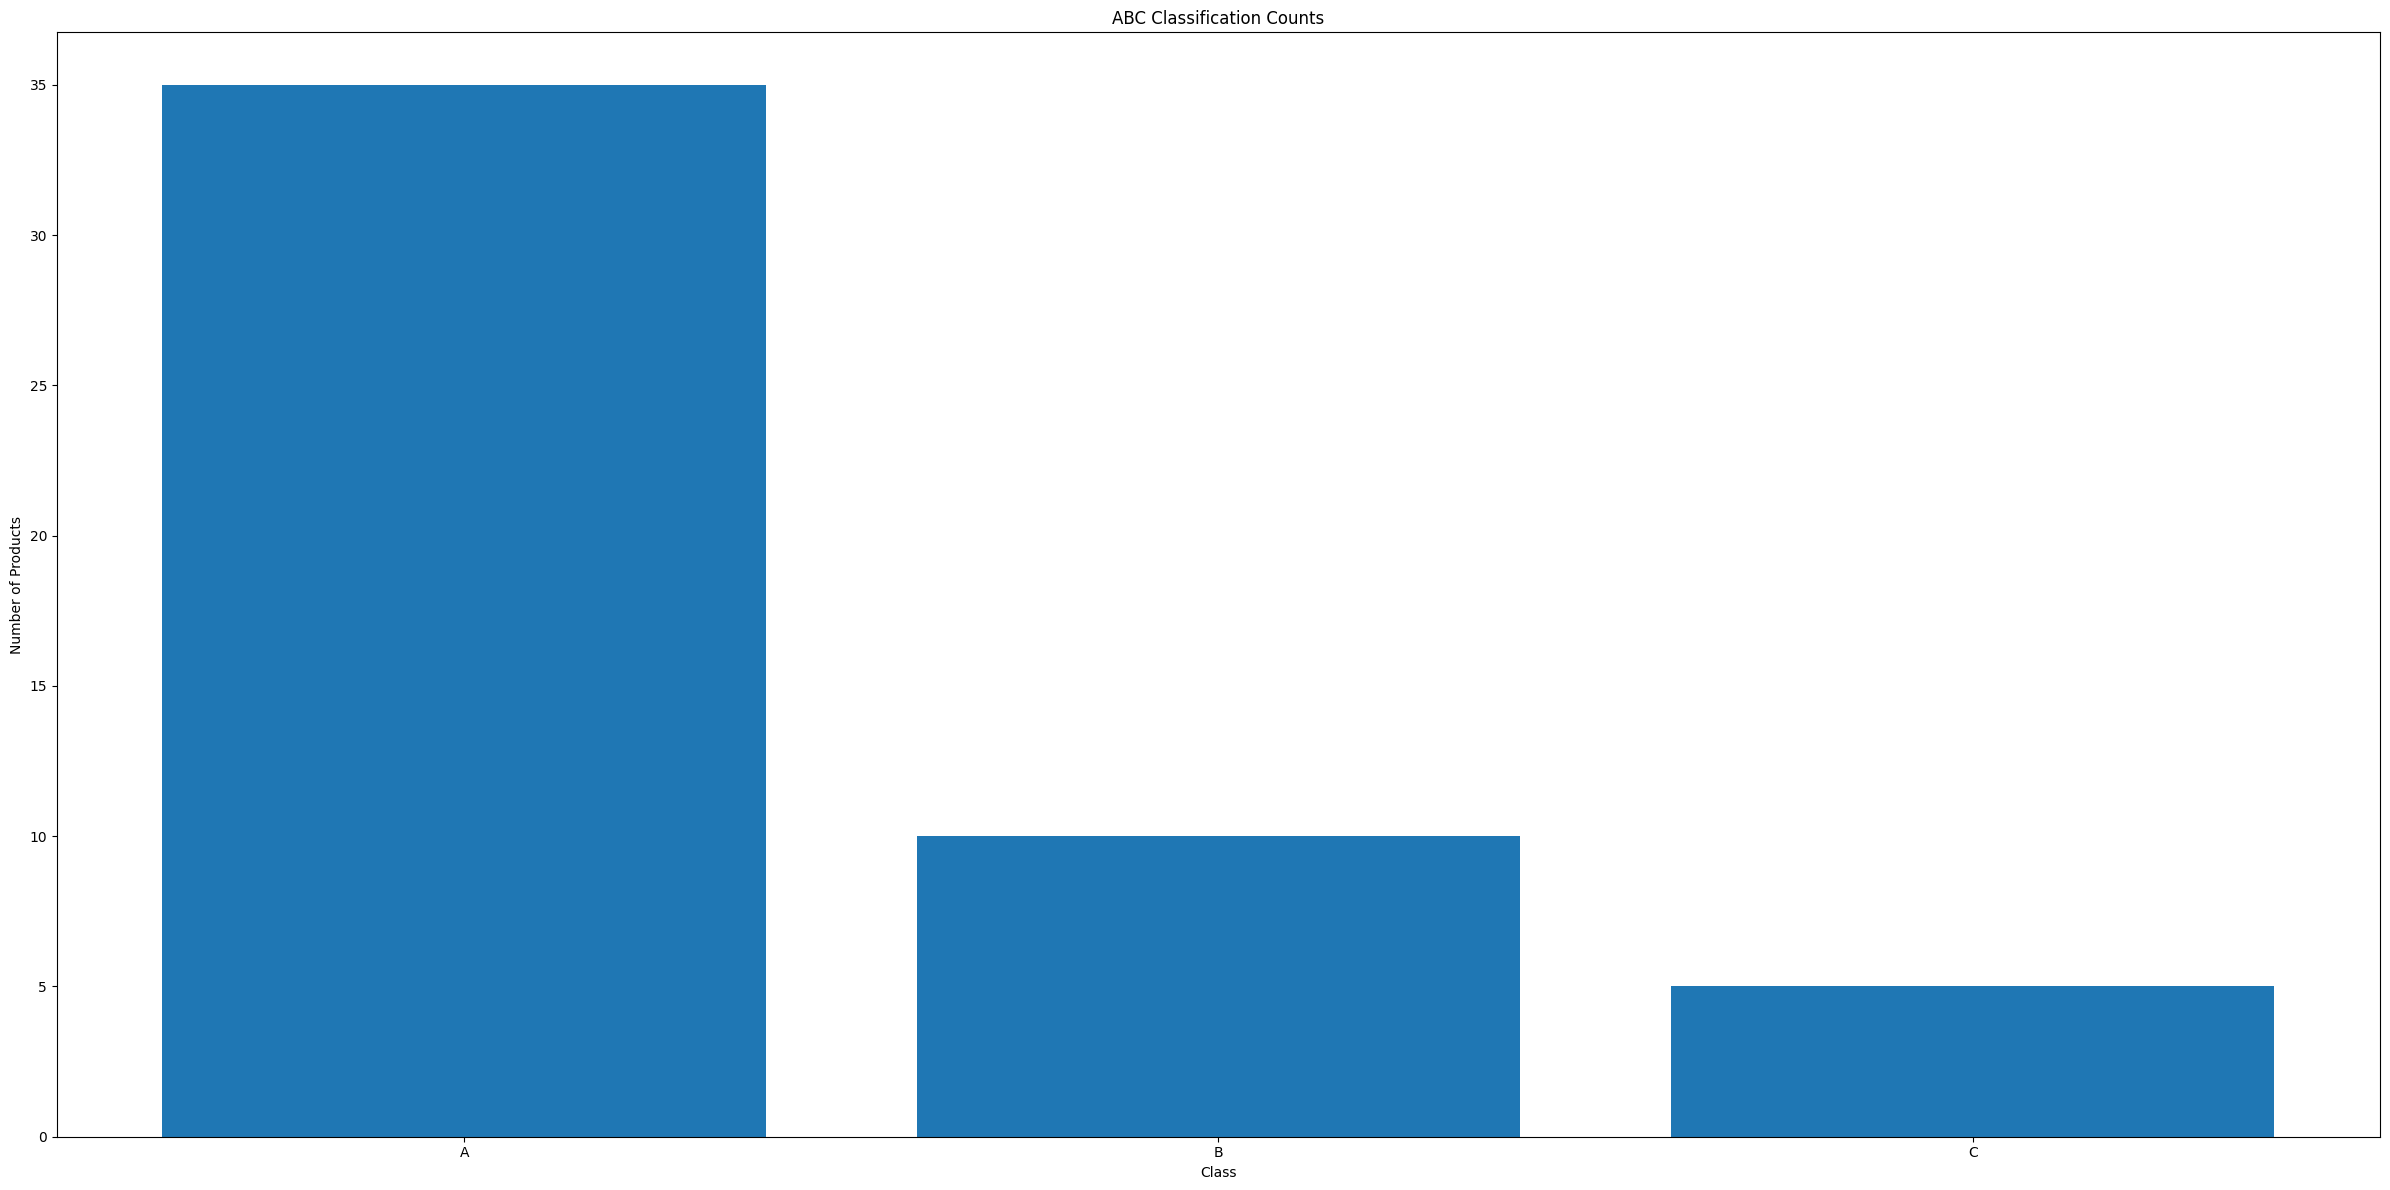

In [27]:
# revenue per product
rev_tot = rev.groupby('productId')['revenue'].sum().reset_index()
rev_tot = rev_tot.merge(df_products[['productId','productName']], on='productId').sort_values('revenue', ascending=False)
rev_tot['cumPct'] = rev_tot['revenue'].cumsum() / rev_tot['revenue'].sum() * 100

conds = [
    rev_tot['cumPct'] <= 80,
    rev_tot['cumPct'].between(80,95),
    rev_tot['cumPct'] > 95
]
choices = ['A','B','C']
rev_tot['ABC'] = np.select(conds, choices, default='C')

# count per class
abc_counts = rev_tot['ABC'].value_counts().sort_index()
plt.figure(figsize=(24,12))
plt.bar(abc_counts.index, abc_counts.values)
plt.title('ABC Classification Counts')
plt.xlabel('Class'); plt.ylabel('Number of Products')
plt.tight_layout()
plt.show()


## Demand Forecasting

Simple Holt–Winters on daily sales

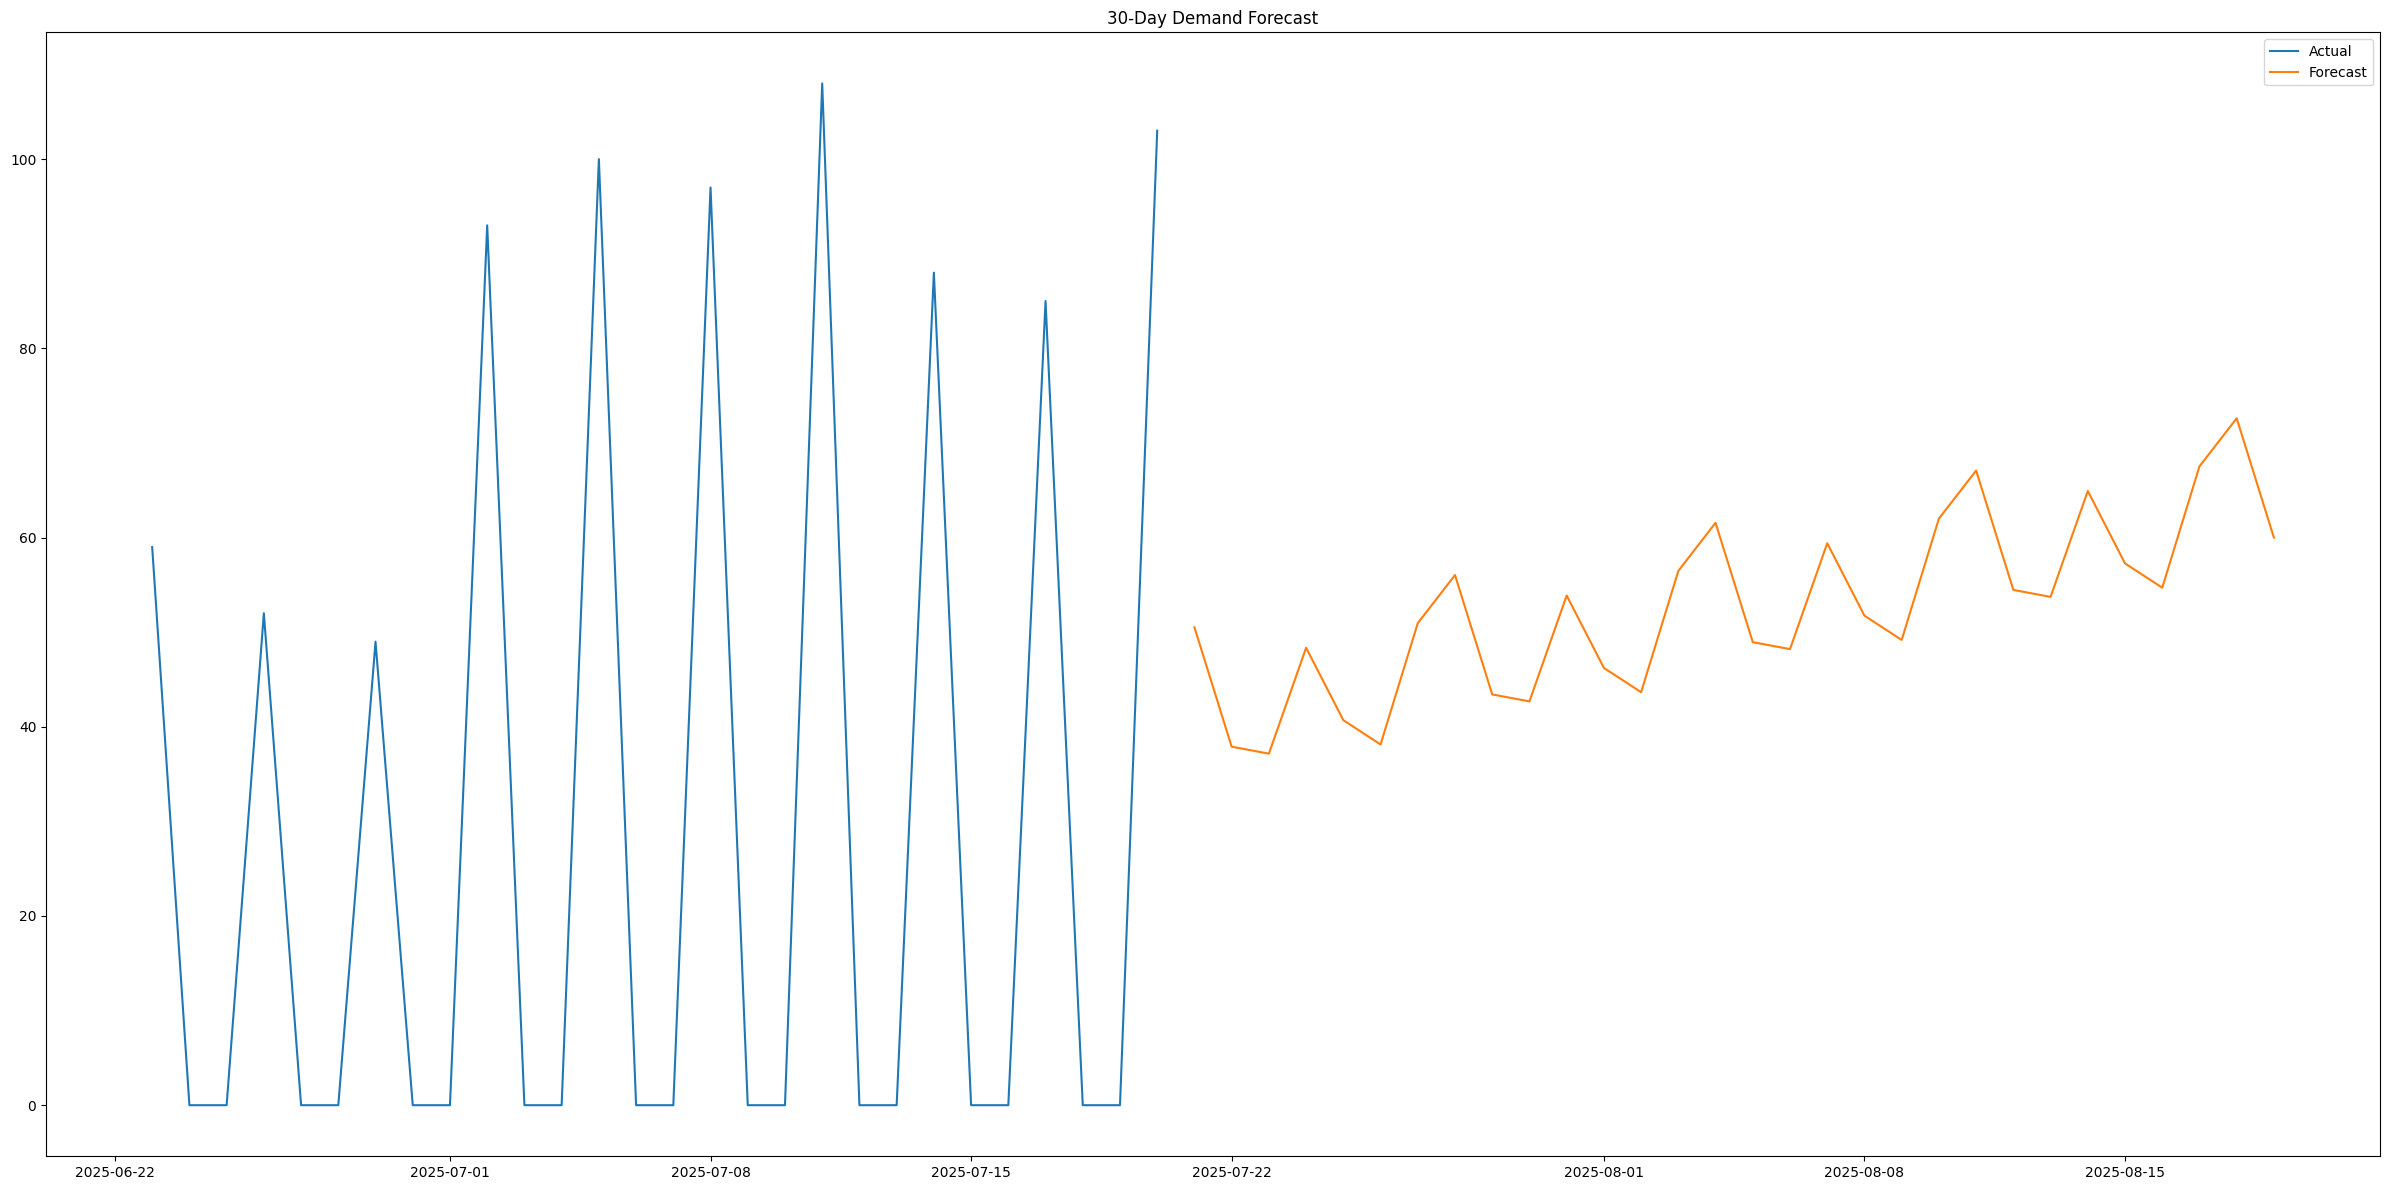

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ts = sales.groupby('dateOrdered')['quantity'].sum().resample('D').sum().fillna(0)

model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=7).fit()
forecast = model.forecast(30)

plt.figure(figsize=(24,12))
plt.plot(ts.index, ts, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(); plt.title('30-Day Demand Forecast'); plt.tight_layout()
plt.show()


## Stockout Rate / Fill Rate

Approximate days when demand > stock

In [29]:
# daily demand vs. inventory at start of day
inv_daily = df_products.set_index('productId')['stockOnHand']  # snapshot; for rolling you'd need daily snapshots
# …for true fill rate you need back‐order data

# simpler: % of order lines where stockOnHand at order < quantityOrdered
merged = df_order_info.merge(df_products[['productId','stockOnHand']], on='productId')
stockouts = (merged['stockOnHand'] < merged['quantity']).mean() * 100
print(f"Stockout Rate (order‐lines): {stockouts:.1f}%")


Stockout Rate (order‐lines): 0.0%


## ROI of Inventory

In [30]:
# pick only the columns we need from products
price_cols = ['productId', 'cost', 'retailPrice']

orders = (
    df_order_info
    .merge(df_products[price_cols], on='productId', how='left')
)

orders['cogs']    = orders['quantity'] * orders['cost']
orders['revenue'] = orders['quantity'] * orders['retailPrice']

total_cogs    = orders['cogs'].sum()
total_revenue = orders['revenue'].sum()

# im under the assumption that 
# 'monetaryValue' = cost × stockOnHand already in Products Table
avg_inv_value = df_products['monetaryValue'].sum()

ROI = (total_revenue - total_cogs) / avg_inv_value * 100
print(f"Total Revenue: PHP{total_revenue:.2f}")
print(f"Total COGS: PHP{total_cogs:.2f}")
print(f"Avg Inventory Value: PHP{avg_inv_value:.2f}")
print(f"Inventory ROI: {ROI:.1f}%")


Total Revenue: PHP34717300.00
Total COGS: PHP34717300.00
Avg Inventory Value: PHP14403328.82
Inventory ROI: 0.0%


In [31]:
# theoretical revenue if you cleared out the warehouse
revenue    = (df_products['stockOnHand'] * df_products['retailPrice']).sum()
total_cogs = (df_products['stockOnHand'] * df_products['cost']).sum()
inv_value  = df_products['monetaryValue'].sum()   # = total_cogs

ROI_pct = (revenue - total_cogs) / inv_value * 100
print(f"Theoretical full-turn ROI: {ROI_pct:.1f}%")


Theoretical full-turn ROI: 1.8%


In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_products)


     productId                                        productName  \
0            1                            LIN YUN JU SUPER ZLC FL   
1            2                           FZD SUPER ALC FL, ST, CS   
2            3                                         FZD CNF FL   
3            4                              SUPER ALC VISCARIA FL   
4            5                                       TIMOBOLL ZLC   
5            6                                        FREITAS ALC   
6            7                                    MIZUTANI JUN FL   
7            8                                  ZHANG JIKE ALC FL   
8            9                             LIN GAO YUAN ALC FL ST   
9           10                            FZD SUPER ZLC FL ST. CS   
10          11                                           REVOLDIA   
11          12                                FRANZISKA ZLC ST FL   
12          13                           AMULTART CARBON FL CP ST   
13          14                    

## Obsolete Inventory / Shrinkage

to check if certain items are obsolete na, not morving stock
pero to do that, we need to count the products that are physically present in one store

sige wag na lang siguro muna

In [33]:
# # df_physical with columns productId, countedUnits
# shrink = df_physical.set_index('productId')['countedUnits'] - df_products.set_index('productId')['stockOnHand']
# print(shrink.sort_values().head(10))  # largest negative = biggest shrinkage
